In [1]:
from pathlib import Path
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from data_scripts import *

tex_fonts = {
    # Use LaTeX to write all text
    # "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

sns.set_theme(
    # context="talk",
    context="paper",
    # rc={"figure.figsize": (8, 6)},
    palette="colorblind6",
    style="whitegrid",
    rc=tex_fonts,
)

CONVERGED = False
NUM_SIMS = 20
YEAR = 365 * 24 * 60 * 60
USE_SIMULATED_TIME = False

if USE_SIMULATED_TIME:
    X_LABEL = "Simulated time, years"
else:
    X_LABEL = "Time step number"


data = {
    "CPR": load_data("thermal_cpr", n_newest=NUM_SIMS),
    "Schur": load_data("thermal_schur", n_newest=NUM_SIMS),
    "Random": load_data("thermal_random", n_newest=NUM_SIMS),
    "Solver Selection": load_data("thermal_dynamic", n_newest=NUM_SIMS),

    # "Solver selection": load_data("thermal_dynamic", n_newest=NUM_SIMS),
    # "Standard exploration": load_data("../3_medium/thermal_eps_default", n_newest=NUM_SIMS)
}

save_media_path = Path('media')
save_media_path.mkdir(exist_ok=True)

COLORS = {
    'CPR': 'C0',
    'Schur': 'C1',
    'Solver Selection': 'C3',
    'Random': 'C4',
}

Loading data:
/home/porepy/solver_selector/examples/1/performance/thermal_cpr_10.npy
/home/porepy/solver_selector/examples/1/performance/thermal_cpr_11.npy
/home/porepy/solver_selector/examples/1/performance/thermal_cpr_12.npy
/home/porepy/solver_selector/examples/1/performance/thermal_cpr_13.npy
/home/porepy/solver_selector/examples/1/performance/thermal_cpr_14.npy
/home/porepy/solver_selector/examples/1/performance/thermal_cpr_15.npy
/home/porepy/solver_selector/examples/1/performance/thermal_cpr_16.npy
/home/porepy/solver_selector/examples/1/performance/thermal_cpr_17.npy
/home/porepy/solver_selector/examples/1/performance/thermal_cpr_18.npy
/home/porepy/solver_selector/examples/1/performance/thermal_cpr_19.npy
/home/porepy/solver_selector/examples/1/performance/thermal_cpr_20.npy
/home/porepy/solver_selector/examples/1/performance/thermal_cpr_21.npy
/home/porepy/solver_selector/examples/1/performance/thermal_cpr_22.npy
/home/porepy/solver_selector/examples/1/performance/thermal_cpr

CPR 0.4080089330673218 0.005060911178588867
CPR 0.40793442726135254 0.005060911178588867
CPR 0.40662145614624023 0.00785684585571289
CPR 0.4045703411102295 0.014173507690429688
CPR 0.4041052261988322 0.014173507690429688
CPR 0.4054398536682129 0.017081737518310547
CPR 0.40645405650138855 0.01718759536743164
CPR 0.40782613224453396 0.022436857223510742
CPR 0.4076998233795166 0.022436857223510742
CPR 0.4073444496501576 0.022436857223510742
CPR 0.40763195355733234 0.022436857223510742
CPR 0.40752055094792294 0.022436857223510742
CPR 0.40783688000270296 0.022436857223510742
CPR 0.4076130708058675 0.022436857223510742
CPR 0.40803855657577515 0.022436857223510742
CPR 0.4079569648293888 0.022436857223510742
CPR 0.40762727790408665 0.022436857223510742
CPR 0.4073775191056101 0.022436857223510742
CPR 0.40749416351318357 0.022436857223510742
Schur 0.4489719867706299 0.0013322830200195312
Schur 0.44677964846293133 0.007243156433105469
Schur 0.4482923746109009 0.01043558120727539
Schur 0.447083759

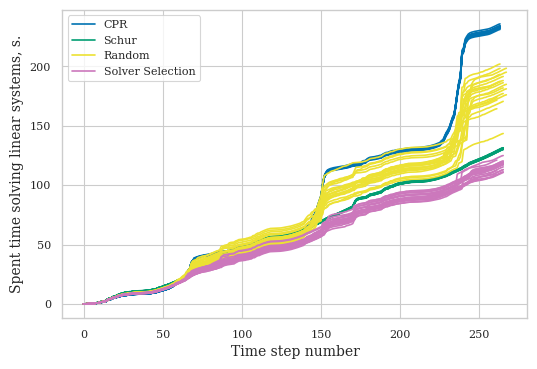

In [2]:
plt.figure(figsize=(6, 4))
for name, values in data.items():
    total = []
    make_label = True
    for perf in values:
        result = sum_per_time_step(
            make_solve_linear_system_time(perf, converged=CONVERGED),
            perf,
            converged=CONVERGED,
        )

        total.append(result[-1])
        result = np.cumsum(result)
        x = np.arange(len(result))
        if USE_SIMULATED_TIME:
            x = make_simulation_time(perf, converged=CONVERGED) / YEAR

        if make_label:
            plt.plot(x, result, color=COLORS[name], label=name)
            make_label = False
        else:
            plt.plot(x, result, color=COLORS[name])
            print(name, np.mean(total), np.max(total) - np.min(total))

plt.legend()
plt.xlabel(X_LABEL)
plt.ylabel("Spent time solving linear systems, s.")

if save_media_path is not None:
    plt.savefig(save_media_path / "thermal_performance.pdf", bbox_inches="tight")

CPR 233.15877423286437 4.644997835159302
Schur 130.7480176448822 1.5187442302703857
Random 182.63859477043152 58.49619698524475
Solver Selection 116.55245832204818 15.924200534820557


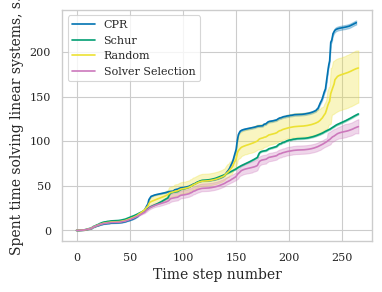

In [3]:
best_time = float('inf')
plt.figure(figsize=(4, 3))
for name, values in data.items():
    result = []
    times = []

    for perf in values:
        vals = np.cumsum(
            sum_per_time_step(
                make_solve_linear_system_time(perf, converged=CONVERGED),
                perf,
                converged=CONVERGED,
            )
        )
        result.append(vals)
        if USE_SIMULATED_TIME:
            times.append(make_simulation_time(perf, converged=CONVERGED) / YEAR)
        else:
            times.append(np.arange(len(vals)))

    total = []
    t_end = []
    interp_data_list = []
    x_space = np.linspace(times[0][0], times[0][-1], 1000)
    for time, result in zip(times, result):
        total.append(result[-1])
        t_end.append(time[-1])
        interp_data_list.append(np.interp(x_space, time, result))

    interp_data = np.array(interp_data_list)
    max_ = np.max(interp_data, axis=0)
    min_ = np.min(interp_data, axis=0)
    mean = np.mean(interp_data, axis=0)
    if mean[-1] < best_time:
        best_time = mean[-1]
        best = mean
    plt.fill_between(x_space, min_, max_, color=COLORS[name], alpha=0.3)
    plt.plot(x_space, mean, color=COLORS[name], label=name)
    print(name, np.mean(total), np.max(total) - np.min(total))
    if USE_SIMULATED_TIME:
        assert np.allclose(t_end, t_end[0], rtol=1e-10)

plt.legend()
plt.xlabel(X_LABEL)
plt.ylabel("Spent time solving linear systems, s.")

if save_media_path is not None:
    plt.savefig(save_media_path / "thermal_performance.pdf", bbox_inches="tight")

CPR
Schur
Random
Solver Selection
Solver Selection (average)


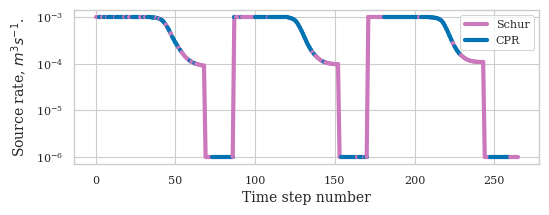

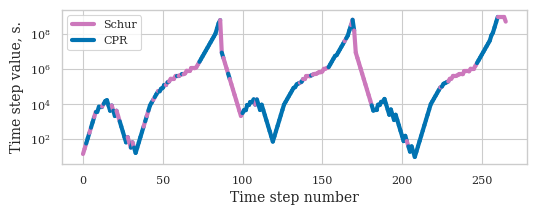

In [4]:
def color_using_schur(x, values, using_schur):
    lw = 3
    if not USE_SIMULATED_TIME:
        x = np.arange(values.size)
    cpr_color = "C0"
    schur_color = "C3"
    label_schur = False
    label_cpr = False

    for i in range(len(x)):
        x_ = x[i : i + 2]
        val = values[i : i + 2]
        if not using_schur[i]:
            kwargs = dict(color=cpr_color)
            if not label_cpr:
                kwargs["label"] = "CPR"
                label_cpr = True
        else:
            kwargs = dict(color=schur_color)
            if not label_schur:
                kwargs["label"] = "Schur"
                label_schur = True
        plt.plot(x_, val, linewidth=lw, **kwargs)
        plt.legend()


def make_using_schur_indices(perf: Sequence[SolverSelectionData], converged=True):
    using_schur = np.array(
        ["schur_cd" in data.config["gmres"]["preconditioner"] for data in perf]
    )
    if converged:
        return using_schur[make_converged_indices(perf)]
    return using_schur


def make_average_decision(values):
    return values[0]
    values = np.array(values, dtype=int)
    values = values.sum(axis=0)
    mean = NUM_SIMS / 2
    return values > mean


for name, vals in data.items():
    print(name)
    if name != 'Solver Selection':
        continue
    using_schur_list = []
    time_step_list = []
    inlet_rate_list = []
    sim_time_list = []
    for perf in vals:
        using_schur_list.append(make_using_schur_indices(perf, converged=CONVERGED))
        time_step_list.append(make_time_step(perf, converged=CONVERGED))
        inlet_rate_list.append(make_inlet_rate(perf, converged=CONVERGED))
        sim_time_list.append(make_simulation_time(perf, converged=CONVERGED))

    using_schur_mean = make_average_decision(using_schur_list)

    print(name, "(average)")
    plt.figure(figsize=(6, 2))
    color_using_schur(sim_time_list[0], inlet_rate_list[0], using_schur_mean)
    plt.ylabel("Source rate, $m^3 s^{-1}$.")
    plt.xlabel(X_LABEL)
    plt.yscale("log")
    if save_media_path is not None:
        plt.savefig(save_media_path / f"thermal_source_{name}.pdf", bbox_inches="tight")
    plt.show()

    plt.figure(figsize=(6, 2))
    plt.ylabel("Time step value, s.")
    plt.xlabel(X_LABEL)
    color_using_schur(sim_time_list[0], time_step_list[0], using_schur_mean)
    plt.yscale("log")
    if save_media_path is not None:
        plt.savefig(save_media_path / f"thermal_dt_{name}.pdf", bbox_inches="tight")
    plt.show()

CPR 0.40749416351318357 0.022436857223510742
Schur 0.4459496021270752 0.01273036003112793


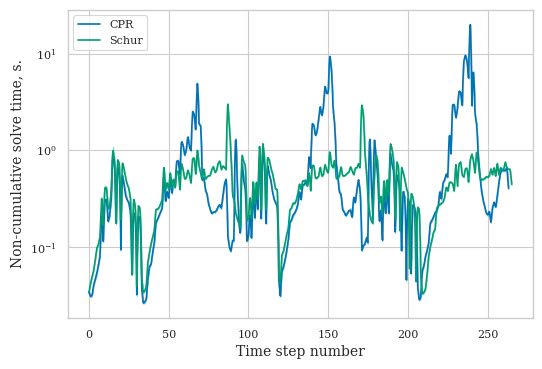

In [5]:
plt.figure(figsize=(6, 4))

for name, values in data.items():
    if name not in ('CPR', 'Schur'):
        continue
    result = []
    times = []

    for perf in values:
        vals = sum_per_time_step(
            make_solve_linear_system_time(perf, converged=CONVERGED),
            perf,
            converged=CONVERGED,
        )
        result.append(vals)
        if USE_SIMULATED_TIME:
            times.append(make_simulation_time(perf, converged=CONVERGED) / YEAR)
        else:
            times.append(np.arange(len(vals)))

    total = []
    t_end = []
    interp_data_list = []
    x_space = np.linspace(times[0][0], times[0][-1], 1000)
    for time, result in zip(times, result):
        total.append(result[-1])
        t_end.append(time[-1])

        interp_data_list.append(np.interp(x_space, time, result))

    interp_data = np.array(interp_data_list)
    max_ = np.max(interp_data, axis=0)
    min_ = np.min(interp_data, axis=0)
    mean = np.mean(interp_data, axis=0)

    plt.fill_between(x_space, min_, max_, color=COLORS[name], alpha=0.3)
    plt.plot(x_space, mean, color=COLORS[name], label=name)
    print(name, np.mean(total), np.max(total) - np.min(total))
    assert np.allclose(t_end, t_end[0], rtol=1e-10)

plt.legend()
plt.xlabel(X_LABEL)
plt.ylabel("Non-cumulative solve time, s.")
plt.yscale('log')

CPR 86.0 0.0
Schur 40.0 0.0


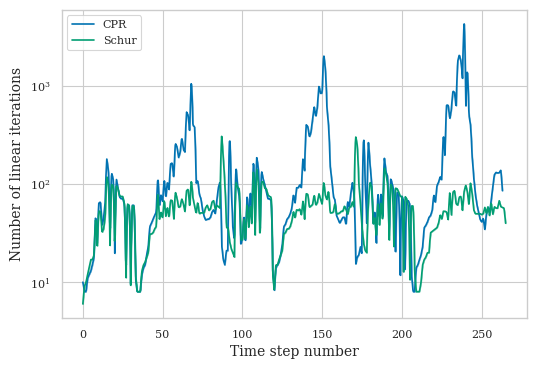

In [6]:
plt.figure(figsize=(6, 4))

for name, values in data.items():
    if name not in ('CPR', 'Schur'):
        continue
    result = []
    times = []

    for perf in values:
        vals = sum_per_time_step(
            make_num_linear_iters(perf, converged=CONVERGED),
            perf,
            converged=CONVERGED,
        )
        result.append(vals)
        if USE_SIMULATED_TIME:
            times.append(make_simulation_time(perf, converged=CONVERGED) / YEAR)
        else:
            times.append(np.arange(len(vals)))

    total = []
    t_end = []
    interp_data_list = []
    x_space = np.linspace(times[0][0], times[0][-1], 1000)
    for time, result in zip(times, result):
        total.append(result[-1])
        t_end.append(time[-1])

        interp_data_list.append(np.interp(x_space, time, result))

    interp_data = np.array(interp_data_list)
    max_ = np.max(interp_data, axis=0)
    min_ = np.min(interp_data, axis=0)
    mean = np.mean(interp_data, axis=0)

    plt.fill_between(x_space, min_, max_, color=COLORS[name], alpha=0.3)
    plt.plot(x_space, mean, color=COLORS[name], label=name)
    print(name, np.mean(total), np.max(total) - np.min(total))
    assert np.allclose(t_end, t_end[0], rtol=1e-10)

plt.legend()
plt.xlabel(X_LABEL)
plt.ylabel("Number of linear iterations")
plt.yscale('log')